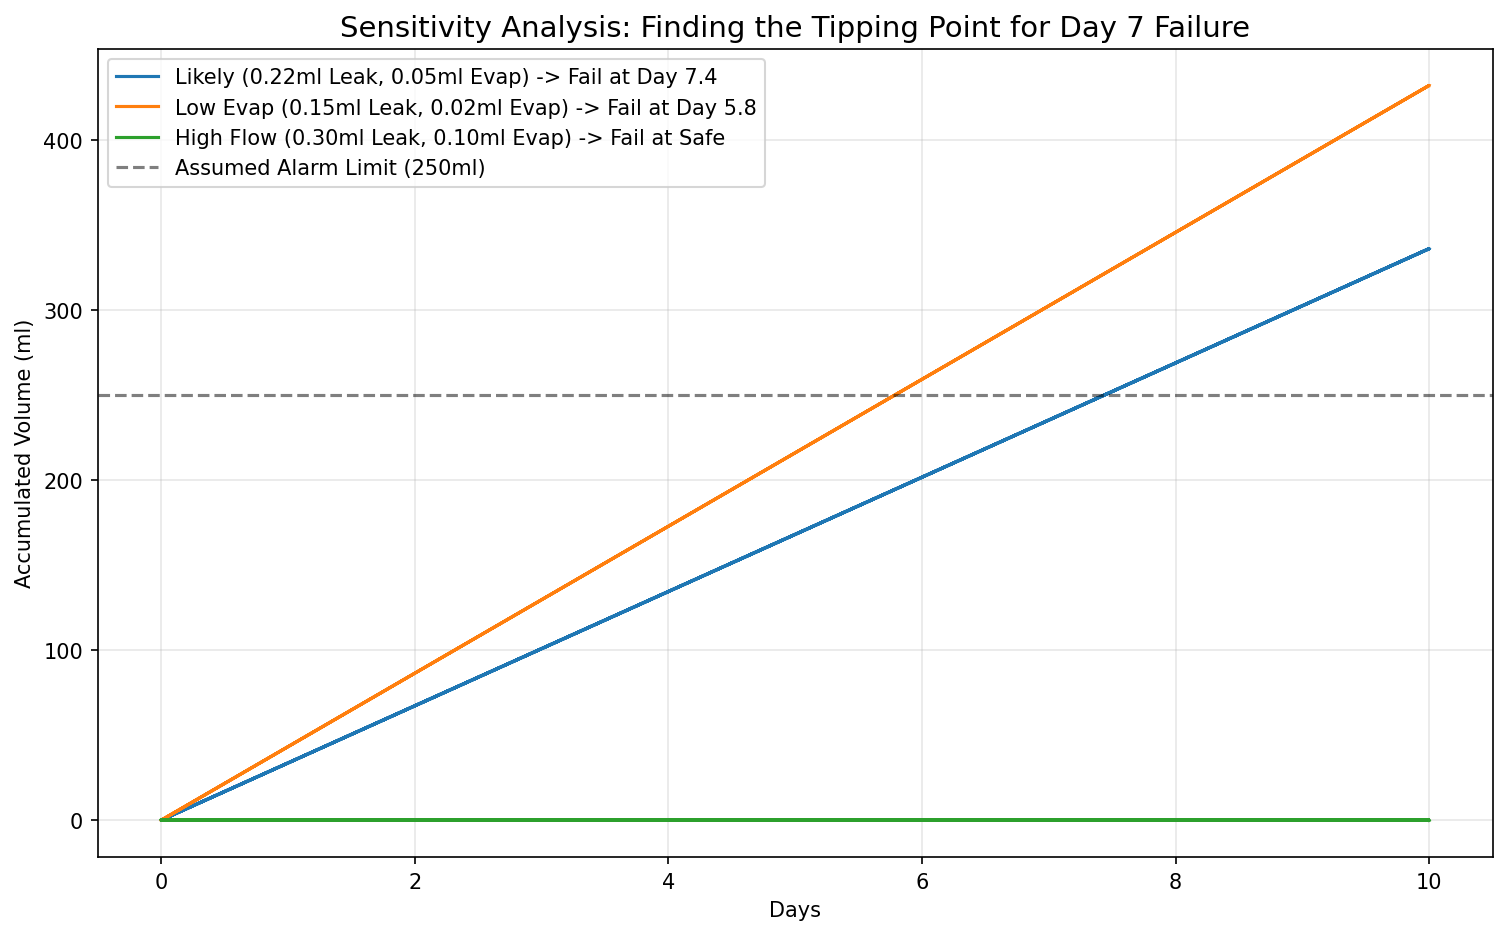

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class FabUncertaintyModel:
    """
    Simulates RRC leak accumulation considering that parameters 
    (Evaporation, Threshold) are estimated assumptions.
    Author: [Alex Chen/Chen Yun Hsaing/app258369]
    """
    def __init__(self, nozzles=6, flow_per_nozzle=40, purge_sec=30):
        self.purge_vol = nozzles * flow_per_nozzle * purge_sec # 7200ml per cycle
        
    def simulate_leak(self, interval_min, leak_per_cycle, evap_rate, threshold, days=10):
        steps = int(days * 24 * 60)
        time_axis = np.linspace(0, days, steps)
        
        volume = 0.0
        history = []
        fail_day = None
        
        for t in range(steps):
            if t % interval_min == 0:
                volume += leak_per_cycle
            
            # Physics Logic: Accumulation only happens if Leak > Evaporation
            volume = max(0, volume - evap_rate)
            history.append(volume)
            
            if fail_day is None and volume >= threshold:
                fail_day = t / (24 * 60)
                
        return time_axis, np.array(history), fail_day

# --- Running Sensitivity Analysis ---
# We test different "Guess" scenarios to see how they impact the Day 7 failure.
model = FabUncertaintyModel()
scenarios = [
    {"leak": 0.22, "evap": 0.05, "label": "Likely (0.22ml Leak, 0.05ml Evap)"},
    {"leak": 0.15, "evap": 0.02, "label": "Low Evap (0.15ml Leak, 0.02ml Evap)"},
    {"leak": 0.30, "evap": 0.10, "label": "High Flow (0.30ml Leak, 0.10ml Evap)"}
]

plt.figure(figsize=(12, 7), dpi=150)
for s in scenarios:
    t, vol, fail = model.simulate_leak(3.0, s['leak'], s['evap'], threshold=250)
    plt.plot(t, vol, label=f"{s['label']} -> Fail at {f'Day {fail:.1f}' if fail else 'Safe'}")


plt.axhline(y=250, color='black', ls='--', alpha=0.5, label='Assumed Alarm Limit (250ml)')
plt.title("Sensitivity Analysis: Finding the Tipping Point for Day 7 Failure", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Accumulated Volume (ml)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()